## Registering Drone Dataset for Detectron2 models

The dataset is available for download here: https://www.kaggle.com/bulentsiyah/semantic-drone-dataset. For the purposes of this notebook, the dataset has been reuploaded to S3, fully preserving it's folder structure. 

Let's download it locally.

In [ ]:
! aws s3 cp s3://d2-blog/ . --recursive

In [ ]:
# check downloaded folder
! ls -al semantic_drone_dataset/

## Install Detectron2

To run this notebook, you will need to have detectron2 installed locally on notebook instance. In case of Sagemaker Managed Notebooks with GPU devices (e.g. p3 family), feel free to use install instructions below:
1. Open sepearate terminal window and run `source activate pytorch_p36` command.
2. Install newer version of gcc in order to compile detectron2 locally: `sudo yum install gcc72 gcc72-c++`
3. Select a new version of gcc to be default compiler: `sudo update-alternatives --config gcc`
3. `conda install pytorch torchvision -c pytorch`
4. `pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'`
5. `pip install 'git+https://github.com/facebookresearch/fvcore'`
6. `export FORCE_CUDA="1"`
7. `export TORCH_CUDA_ARCH_LIST="Volta"`
8. `pip install 'git+https://github.com/facebookresearch/detectron2.git'`


We will use re-use parsing scripts for cityscapes dataset. Hence, need to install it too:

9. `python -m pip install cityscapesscripts`

In [ ]:
import detectron2 # check that detectron2 was properly installed

## Dataset preparations

Detectron2 includes set of utilities for dataloading and vizualization. Check this [Cityscape sample](https://detectron2.readthedocs.io/_modules/detectron2/data/datasets/cityscapes.html) to get genereal idea.

We'll follow the same approach to process Drone Segmentation. Let's review custom scripts.

In [ ]:
! pygmentize drone_dataset_processing.py

## Visualize dataset

{'file_name': 'semantic_drone_dataset/original_images/258.jpg', 'sem_seg_file_name': 'semantic_drone_dataset/label_images_semantic/258.png', 'height': 4000, 'width': 6000}


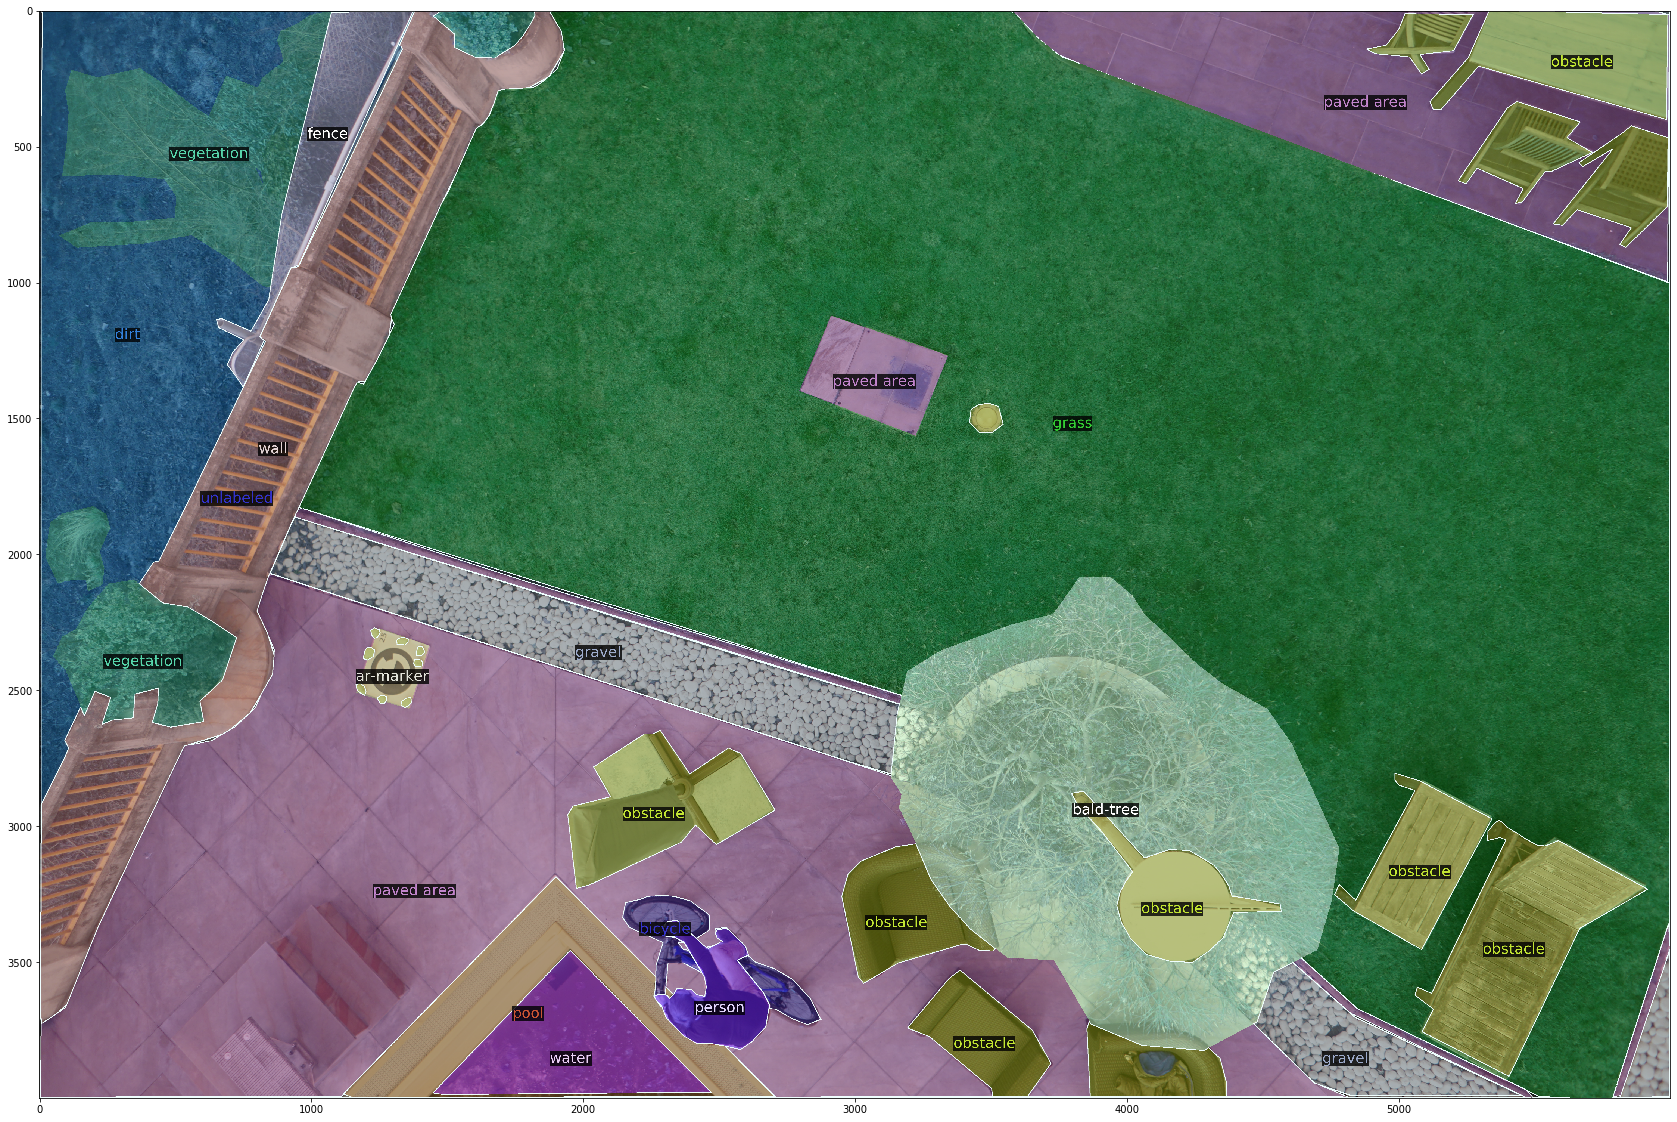

In [24]:
from detectron2.data.catalog import Metadata
from detectron2.utils.visualizer import Visualizer
import os
import numpy as np
from PIL import Image
from fvcore.common.file_io import PathManager
import cv2
from matplotlib import pyplot as plt
# from IPython.display import Image

from drone_dataset_processing import load_drone_semantic, labels

dirname = "drone-data-vis"
os.makedirs(dirname, exist_ok=True)

dicts = load_drone_semantic(
    "semantic_drone_dataset/original_images/", 
    "semantic_drone_dataset/label_images_semantic/")

stuff_colors = [k.color for k in labels if k.trainId != 255]
stuff_classes = [k.name for k in labels if k.trainId != 255]
meta = Metadata().set(stuff_colors=stuff_colors, stuff_classes=stuff_classes)


import random
d = random.choice(dicts)
# d = dicts[247]

print(d)

img = np.array(Image.open(PathManager.open(d["file_name"], "rb")))
visualizer = Visualizer(img, metadata=meta)
vis = visualizer.draw_dataset_dict(d)
overlay_im = vis.get_image()[:, :, ::-1]
plt.figure(figsize = (30,20))
plt.imshow(overlay_im)

## Train with Detectron2

In [16]:
from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_name = "drone_semantic_train"
image_dir = "semantic_drone_dataset/original_images/" 
gt_dir = "semantic_drone_dataset/label_images_semantic/"
stuff_colors = [k.color for k in labels if k.trainId != 255]
stuff_classes = [k.name for k in labels if k.trainId != 255]


DatasetCatalog.register(dataset_name, lambda d=d: load_drone_semantic(image_dir, gt_dir))
MetadataCatalog.get(dataset_name).set(stuff_colors=stuff_colors, stuff_classes=stuff_classes,
                                      evaluator_type="sem_seg") # built-in evaluator for semantic seg task

drone_meta = MetadataCatalog.get(dataset_name)

In [17]:
print(drone_meta)

Metadata(evaluator_type='sem_seg', name='drone_semantic_train_2', stuff_classes=['unlabeled', 'paved area', 'dirt', 'grass', 'gravel', 'water', 'rocks', 'pool', 'vegetation', 'roof', 'wall', 'window', 'door', 'fence', 'fence-pole', 'person', 'dog', 'car', 'bicycle', 'tree', 'bald-tree', 'ar-marker', 'obstacle', 'conflicting'], stuff_colors=[(0, 0, 0), (128, 64, 128), (130, 76, 0), (0, 102, 0), (112, 103, 87), (228, 42, 168), (48, 41, 30), (0, 50, 89), (107, 142, 35), (70, 70, 70), (102, 102, 156), (254, 228, 12), (254, 148, 12), (190, 153, 153), (153, 153, 153), (255, 22, 96), (102, 51, 0), (9, 143, 150), (119, 11, 32), (51, 51, 0), (190, 250, 190), (112, 150, 146), (2, 135, 115), (255, 0, 0)])


In [19]:
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog
from detectron2.engine import DefaultTrainer, default_argument_parser, default_setup, hooks, launch
from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    SemSegEvaluator,
    verify_results,
)

In [39]:
# Do initial configuration

config_file = "Cityscapes/mask_rcnn_R_50_FPN.yaml"

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(config_file))
cfg.DATASETS.TRAIN = ("drone_semantic_train",)
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_file)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 23
cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = 23
cfg.MODEL.SEM_SEG_HEAD.IGNORE_VALUE = 0 # ignore "unlabeled index"

cfg.OUTPUT_DIR = "sem_seg_output"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [40]:
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/16 22:53:38 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[06/16 22:53:39 d2.data.common]: Serializing 400 elements to byte tensors and concatenating them all ...
[06/16 22:53:39 d2.data.common]: Serialized dataset takes 0.07 MiB
[06/16 22:53:39 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(800, 832, 864, 896, 928, 960, 992, 1024), max_size=2048, sample_style='choice'), RandomFlip()]
[06/16 22:53:39 d2.data.build]: Using training sampler TrainingSampler
[06/16 22:53:39 d2.engine.train_loop]: Starting training from iteration 0
ERROR [06/16 22:53:41 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/detectron2/engine/train_loop.py", line 132, in train
    self.run_step()
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/detectron2/engine/train_loop.py", line 215, in run_step
    loss_dict = self.model(data)
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/

TypeError: 'NoneType' object is not iterable